My Dnoising NMR spectroscopy data

In [1]:
import numpy as np
import pywt
from scipy.fft import fft, rfft
from scipy.fft import fftfreq, rfftfreq
from scipy.ndimage.filters import maximum_filter
import matplotlib.pyplot as plt
import sys
import statistics 
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import UnivariateSpline


# import functions as proc

C:\Users\chiar\AppData\Local\Temp\ipykernel_92844\288285219.py:5: DeprecationWarning: Please use `maximum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import maximum_filter


In [14]:
# Data generation 
t = np.arange(0, 2, 0.001)

fid1 = 100*np.exp(-t / 2.1) * np.cos(2 * np.pi * -100 * t) + 100*1j*np.exp(-t / 2.1) * np.sin(2 * np.pi * -100 * t)
fid2 = 10*np.exp(-t / 2.1) * np.cos(2 * np.pi * -110 * t) + 10*1j*np.exp(-t / 2.1) * np.sin(2 * np.pi * -110 * t)
fid9 =  80*np.exp(-t / 2.1) * np.cos(2 * np.pi * -120 * t) + 80*1j*np.exp(-t / 2.1) * np.sin(2 * np.pi * -120 * t)
# fid2 = 1000*np.exp(-t / 0.01) * np.cos(2 * np.pi * -800 * t) + 1000*1j*np.exp(-t / 0.01) * np.sin(2 * np.pi * -800 * t)
fid3 = 500*np.exp(-t / 0.08) * np.cos(2 * np.pi * 310 * t) + 500*1j*np.exp(-t / 0.08) * np.sin(2 * np.pi * 310 * t)
fid4 = 1000*np.exp(-t / 0.075) * np.cos(2 * np.pi * 320* t) + 1000*1j*np.exp(-t / 0.075) * np.sin(2 * np.pi * 320 * t)

fid5 = 50*np.exp(-t / 1) * np.cos(2 * np.pi * -200 * t) + 50*1j*np.exp(-t / 1) * np.sin(2 * np.pi * -200 * t)
fid6 = 1000*np.exp(-t / 0.075) * np.cos(2 * np.pi * -420* t) + 1000*1j*np.exp(-t / 0.075) * np.sin(2 * np.pi * -420 * t)


fid = fid1+fid2+fid3+fid4+fid5+fid6+fid9

dt = t[2] - t[1] 
N = len(fid)
freqs = fftfreq(N, dt)

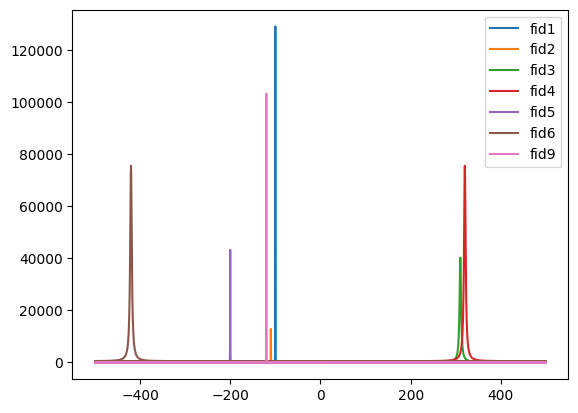

In [15]:
plt.plot(freqs, np.real(fft(fid1)),  label='fid1')
plt.plot(freqs,np.real(fft(fid2)),  label='fid2')
plt.plot(freqs,np.real(fft(fid3)),  label='fid3')
plt.plot(freqs,np.real(fft(fid4)),  label='fid4')
plt.plot(freqs,np.real(fft(fid5)),  label='fid5')
plt.plot(freqs,np.real(fft(fid6)),  label='fid6')
plt.plot(freqs,np.real(fft(fid9)),  label='fid9')
# plt.plot(freqs,np.real(fft(fid)),  label='fidTot')
# Adding legend
plt.legend()
# Display the plot
plt.show()

C:\Users\chiar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\chiar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'Magnitude')

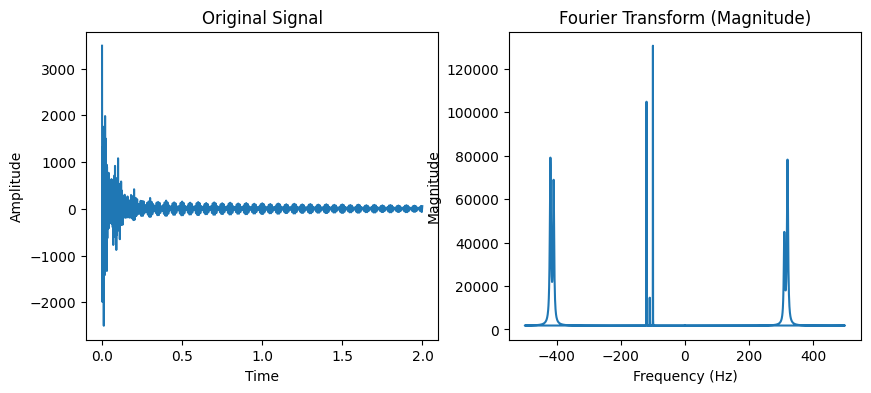

In [736]:
# Plotting data 

plt.figure(figsize=(10, 4))


# Plot the original signal
plt.subplot(1, 2, 1)
plt.plot(t, fid)
plt.title('Original Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')

# Plot the magnitude of the Fourier Transform
plt.subplot(1, 2, 2)
plt.plot(freqs, np.real(fft(fid)))
#plt.plot(rfftfreq(N, dt), 2*np.abs(rfft(fid))/N)
plt.title('Fourier Transform (Magnitude)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

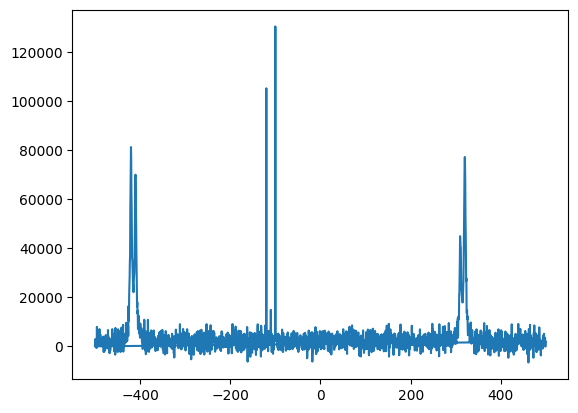

In [737]:
# Adding noise
pure = np.real(fft(fid))
noise = np.random.normal(0,  800, len(pure))  # Generation Gaussian noise

noisy_sgn = pure + 3 * noise          # Application noise to the pure sample
plt.plot(freqs, np.real(noisy_sgn))

In [807]:
def base_deriv(s0):
    """
    Function to determine signal derivative
    Uses equation 5 of Zorin et. al. Magn. Reson. Chem. 2017, 55, 738–746
    
    Parameters
    ----------
    s0  : ndarray
        The real component of a FFT array
    Returns
    -------
    deriv : ndarray
        The derivitive of the data, s0
    """
    deriv = np.zeros((len(s0)))
    for i in range(5,len(s0)-5):
        deriv[i] = (42*(s0[i] - s0[i-1]) + 48*(s0[i+1]-s0[i-2]) + 27*(s0[i+2]-s0[i-3]) + 8*(s0[i+3]-s0[i-4]) + s0[i+4]-s0[i-5])/512
    return deriv

In [808]:
# Signal Region Identifcation 
def signal_region(data, k):

    # Percentage of noise
    np_percentage = 10
    np_sample = round(len(data) * (np_percentage / 100))
    
    # Calculate mean and standard deviation of noise
    mean_noise = np.mean(np.abs(np.real(data[:np_sample])))
    std_noise = np.std(np.real(data[:np_sample]))
    
    # Threshold for noise
    threshold_noise = mean_noise + k * std_noise
    
    # Find indices where data is above threshold (potential signal)
    ind_over = np.where(data > threshold_noise)[0]
    
    # Find consecutive ranges containing signal
    # over = consecutive(ind_over, stepsize=1)
    # temp = np.diff(ind_over)
    # temp2 = np.where(temp == 1)
    # over = ind_over[temp2]  # Range containing the signal
    # first_last = [over[n] for n in (0,-1)]  
    
    return ind_over,threshold_noise
    # return ind_over



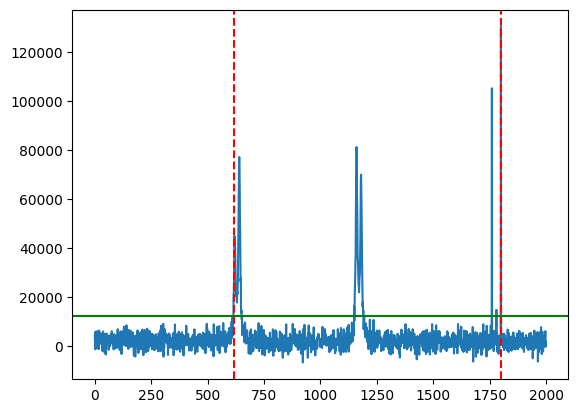

In [740]:
regionSgn, threshold_noise =  signal_region(noisy_sgn,4)

fig, ax = plt.subplots()

plt.plot(np.real(noisy_sgn))
plt.axvline(x=regionSgn[0], color='r', linestyle='--')
plt.axvline(x=regionSgn[-1], color='r', linestyle='--')
plt.axhline(y=threshold_noise, color='g', linestyle='-', linewidth=1.5)


plt.show()

In [809]:
def find_peak_region(signal,threshold_noise):
    map = np.zeros(len(signal))
    for i in range(0, len(signal)): 
        if signal[i]>threshold_noise: 
            map[i]=1

    for i in range(0,len(map)): 
        # map2 = np.zeros(len(map))
        if map[i]==0 and map[i-1]==1: 
            k = i 
            count = 0 
            try:

                while map[k]==0 and k < len(map)-1: 
                    count = count+1
                    if k < len(map)-1:
                        k =k+1 
                   
                if count <20:
                    map[i:k]=1
            except:
                print("Error")
                

    return map

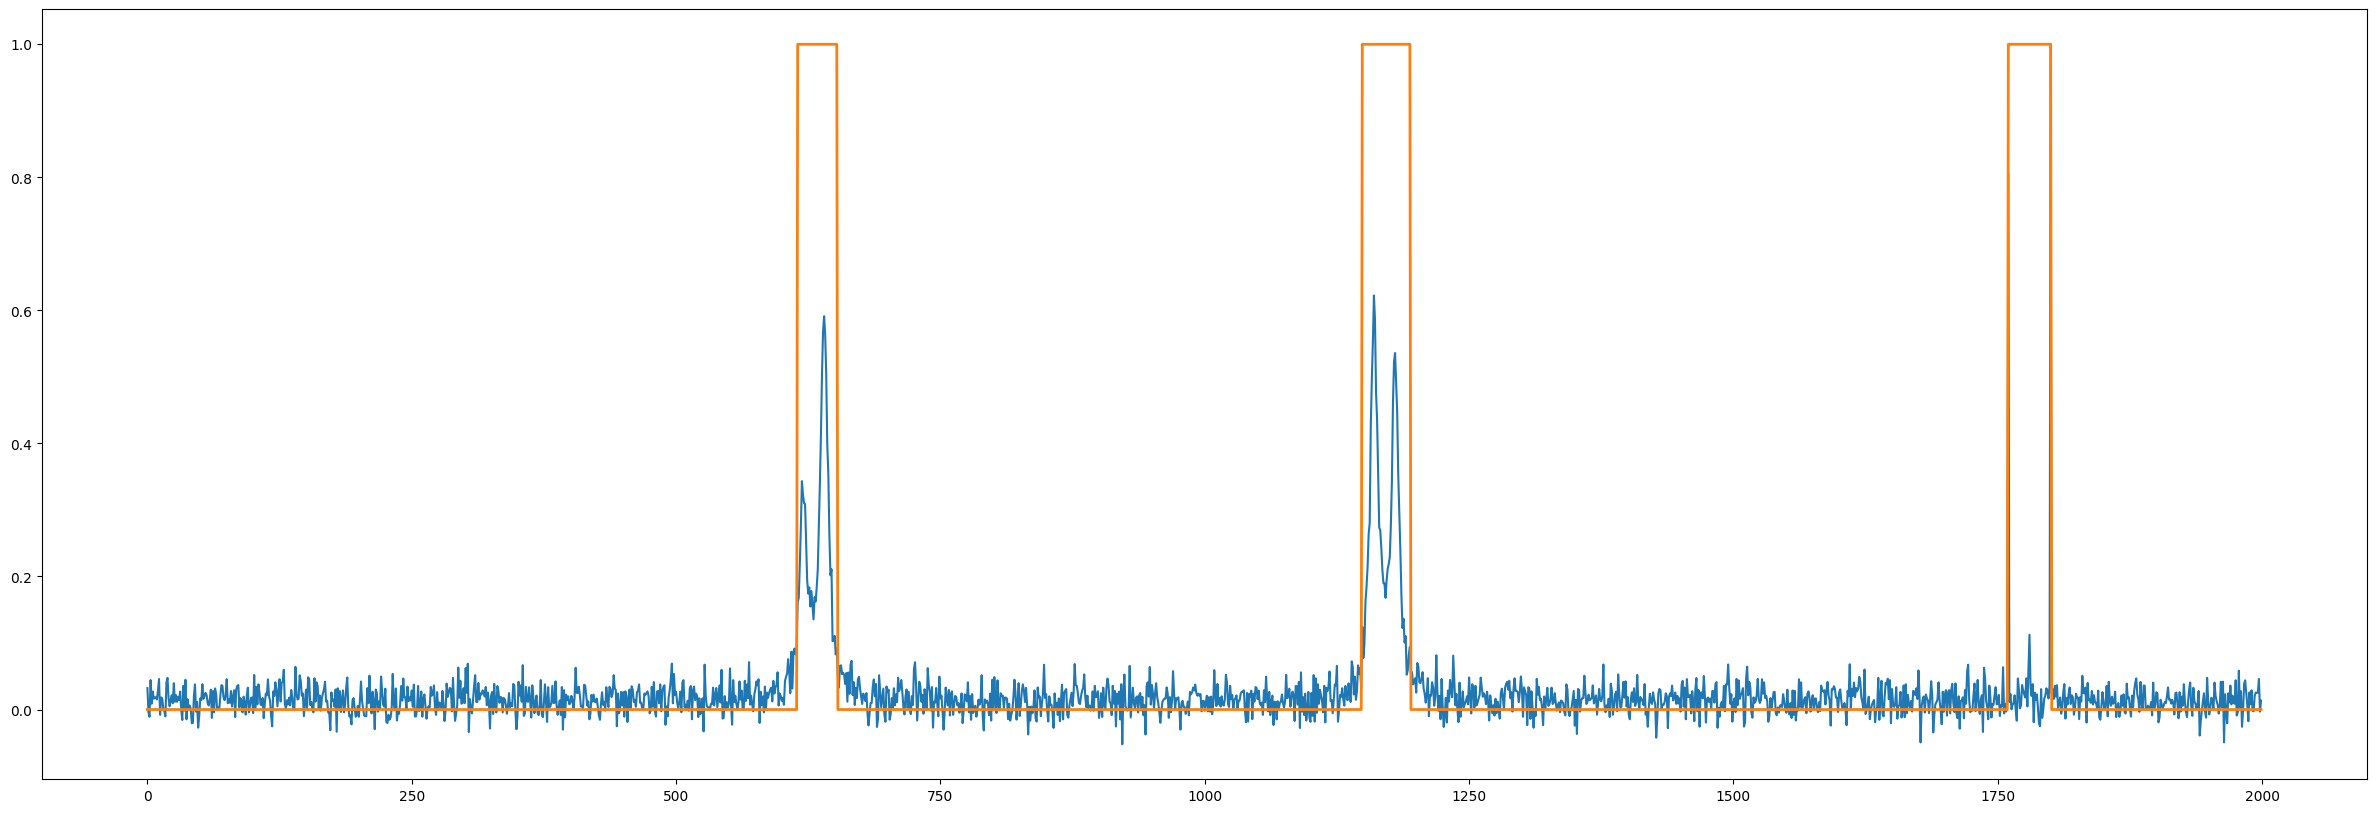

In [742]:
map = find_peak_region(noisy_sgn,threshold_noise)

plt.figure(figsize=(30,10))

plt.plot(np.real(noisy_sgn)/np.max(np.real(noisy_sgn)))
plt.plot(map,linewidth=2)

plt.show()

In [810]:
# consecutive number in an array

def consecutive(data, stepsize=1):
    """"
    basic function to blocks of consecutive number in an array
    """
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

In [811]:
import numpy as np
from scipy.signal import find_peaks

def analyze_peaks(signal, threshold,distance):
    x = np.arange(1, len(signal) + 1)
    y = np.real(signal)

    # get derivatives
    dy = np.diff(y)
    dx = np.diff(x)
    dy_dx = np.concatenate(([0], dy / dx))

    # # plot default annotated peaks
    # plt.subplot(211)
    # ind,  _ = find_peaks(noisy_sgn,  height=threshold_noise, distance=10)
    # plt.plot(x, y)
    # plt.plot(x[ind[:]], y[ind[:]], 'x')
    # plt.xlabel('Time')
    # plt.ylabel('Amplitude')
    # plt.title('Annotated Peaks')

    # # get peaks with width computed by 'findpeaks'
    # locs, pks = find_peaks(y,height=threshold)
    # pks = pks['peak_heights']

    # plt.subplot(212)
    # plt.plot(x, y)
    # plt.plot(locs, pks, '*m')
    # plt.xlabel('Time')
    # plt.ylabel('Amplitude')
    # plt.title('Peaks with Width')

    # get peaks with width computed by 'findpeaks'
    # smooth = gaussian_filter1d(y, 1)
    locs, prop = find_peaks(y, height=threshold, distance = distance ,prominence=True, width=True)

    pks = prop['peak_heights']
    p = prop['prominences']
    peakWidth1 = prop['width_heights']
    
    # compute starting and ending points
    startpoint = np.zeros_like(pks)
    endpoint = np.zeros_like(pks)

    for ii in range(len(pks)):
        # plt.plot([locs[ii] + peakWidth1[ii]*(-0.5), locs[ii] + peakWidth1[ii]*0.5], [pks[ii] - p[ii]/2, pks[ii] - p[ii]/2], 'y')
        sp = np.where((x < locs[ii]) & (dy_dx > 0))
        if np.shape(sp) == 0:
            sp = 0
        else:
            sp=sp[0][-1]
        startpoint[ii] = sp

        ep = np.where((x > locs[ii]) & (dy_dx >= 0))
        if np.shape(ep)==0:
            ep = len(x)
        else:
            ep=ep[0][0]
        endpoint[ii] = ep+1

        # plt.plot(x[int(startpoint[ii])], y[int(startpoint[ii])], 'og')
        # plt.plot(x[int(endpoint[ii])], y[int(endpoint[ii])], 'sr')
    
    # plt.tight_layout()
    # plt.show()
    # compute second type of width using ending and starting points
    PeakWidth2 = []
    PeakWidth2 = [x[int(endpoint[i])] - x[int(startpoint[i])] for i in range(len(endpoint))]
   

    # structure creation containing information about peaks
    PeakInfo = []
    for PeakNum in range(len(locs)):
        if np.shape(locs[PeakNum]) == 0:
            PeakInfo.append({
                'Start': 0, 'End': 0, 'Index': 0,
                'Val': 0, 'PeakWidth': 0
            })
        else:
            PeakInfo.append({
                'Start': startpoint[PeakNum], 'End': endpoint[PeakNum], 'Index': locs[PeakNum],
                'Val': pks[PeakNum], 'PeakWidth': PeakWidth2[PeakNum]
            })

    # filterPeak = [peak for peak in PeakInfo if (peak['End'] - peak['Start']) > 10]
    
    return PeakInfo


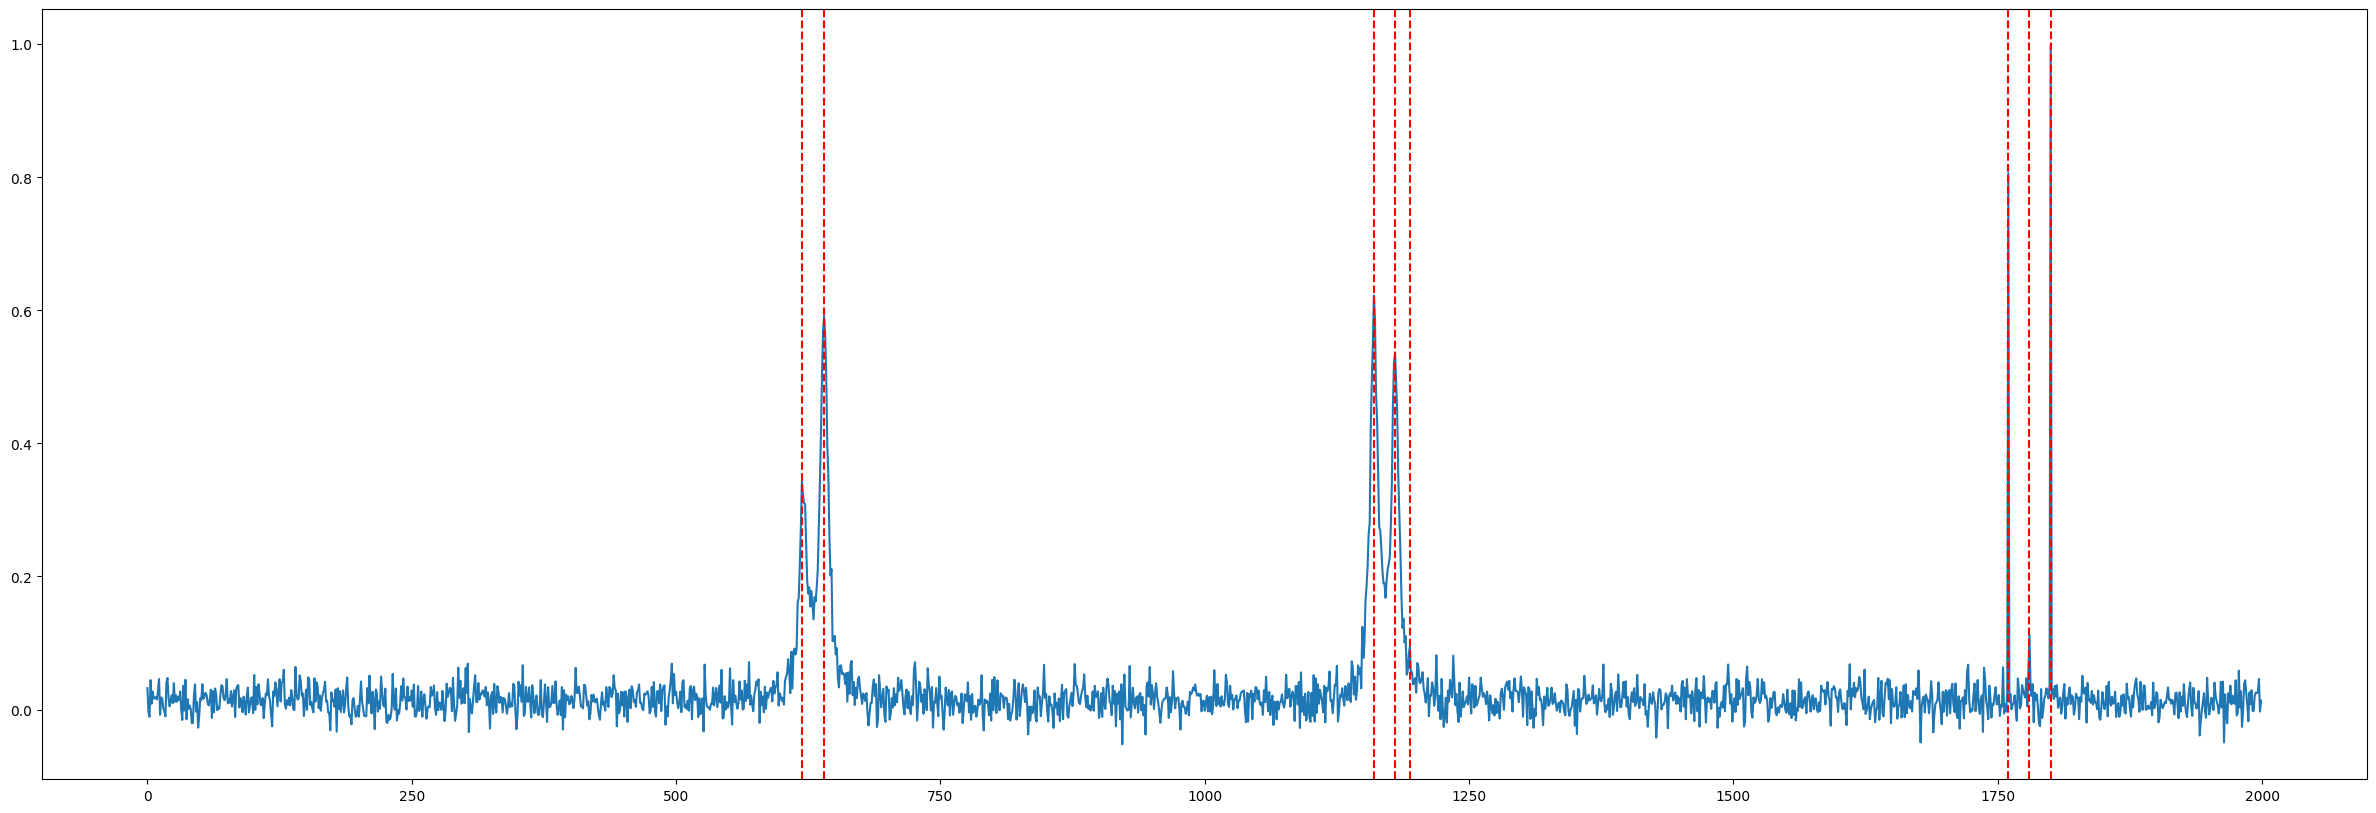

In [745]:
PeakInfo = analyze_peaks(noisy_sgn, threshold_noise, distance=5)


plt.figure(figsize=(30,10))

plt.plot(np.real(noisy_sgn)/np.max(np.real(noisy_sgn)))
for i in range(0, len(PeakInfo)):
    plt.axvline(x=PeakInfo[i]["Index"], color='r', linestyle='--')

plt.show()




In [812]:
def process_blocks(map, noisy_sgn, threshold_noise, buff_size):
    map0 = np.copy(map)
    ind = np.where(map0 == 1)[0]
    cons = consecutive(ind, stepsize=1)  # it contains our box in which should be the signal 

    for ii in range(len(cons)): 
        startblock = cons[ii][0] - buff_size
        endblock = cons[ii][-1] + buff_size
        block_sgn = noisy_sgn[startblock:endblock]              # signal inside the block
        
        blockInfo = analyze_peaks(block_sgn, threshold_noise, distance = 10) # list peak in the block

        # check if there are not peaks into the block 
        if not blockInfo:
            map0[startblock:endblock] = 0 

       
        # check how many peaks there are inside one block, if there are more than 1 peak, check if these are overlapped 
        if len(blockInfo) != 1: 
            num_peak_block = len(blockInfo)                         # number peaks in the block  
            # smooth = gaussian_filter1d(block_sgn, 1)
            smooth = block_sgn

            # find the inflaction point such as the minimum value between the two consecutive peaks
            ip_index_storage = np.zeros(num_peak_block-1)
            ip_bool =  np.zeros(num_peak_block-1)

            for j in range(0,num_peak_block-1):        
                previous_peak = blockInfo[j]["Index"]
                antecedent_peak = blockInfo[j+1]["Index"]
                ip_index = int(np.argmin(smooth[previous_peak:antecedent_peak])+previous_peak)
                ip_index_storage[j] = ip_index
                if block_sgn[ip_index]< threshold_noise: 
                    ip_bool [j] = 1
                else: 
                    ip_bool [j] = 0

            # if len(ip_index) == 1: # there are only two peaks in the block 
            if sum(ip_bool) != 0: # i.p. is in the noise, let's apply function 
                for NumPeak in range(0, len(blockInfo) - 1): 
                        if NumPeak != len(blockInfo):
                            start_noise = blockInfo[NumPeak]['End'] + startblock + 5
                            end_noise = blockInfo[NumPeak + 1]['Start'] + startblock - 5

                            start_noise = int(start_noise)
                            end_noise = int(end_noise)

                            start_signal = int(blockInfo[NumPeak]['Start']+startblock)
                            end_signal = int(blockInfo[NumPeak]['End']+startblock)

                            map0[start_noise:end_noise] = 0
                            map0[start_signal:end_signal] = 1
            else: # i.p. is over the noise, let's separate the peaks 
                for NumInflePOint in range(0, len(blockInfo) - 1): 
                    zero_point= int(ip_index_storage[NumInflePOint]+startblock)
                    

                    map0[zero_point] = 0
                  
                   
                    
               
    return map0


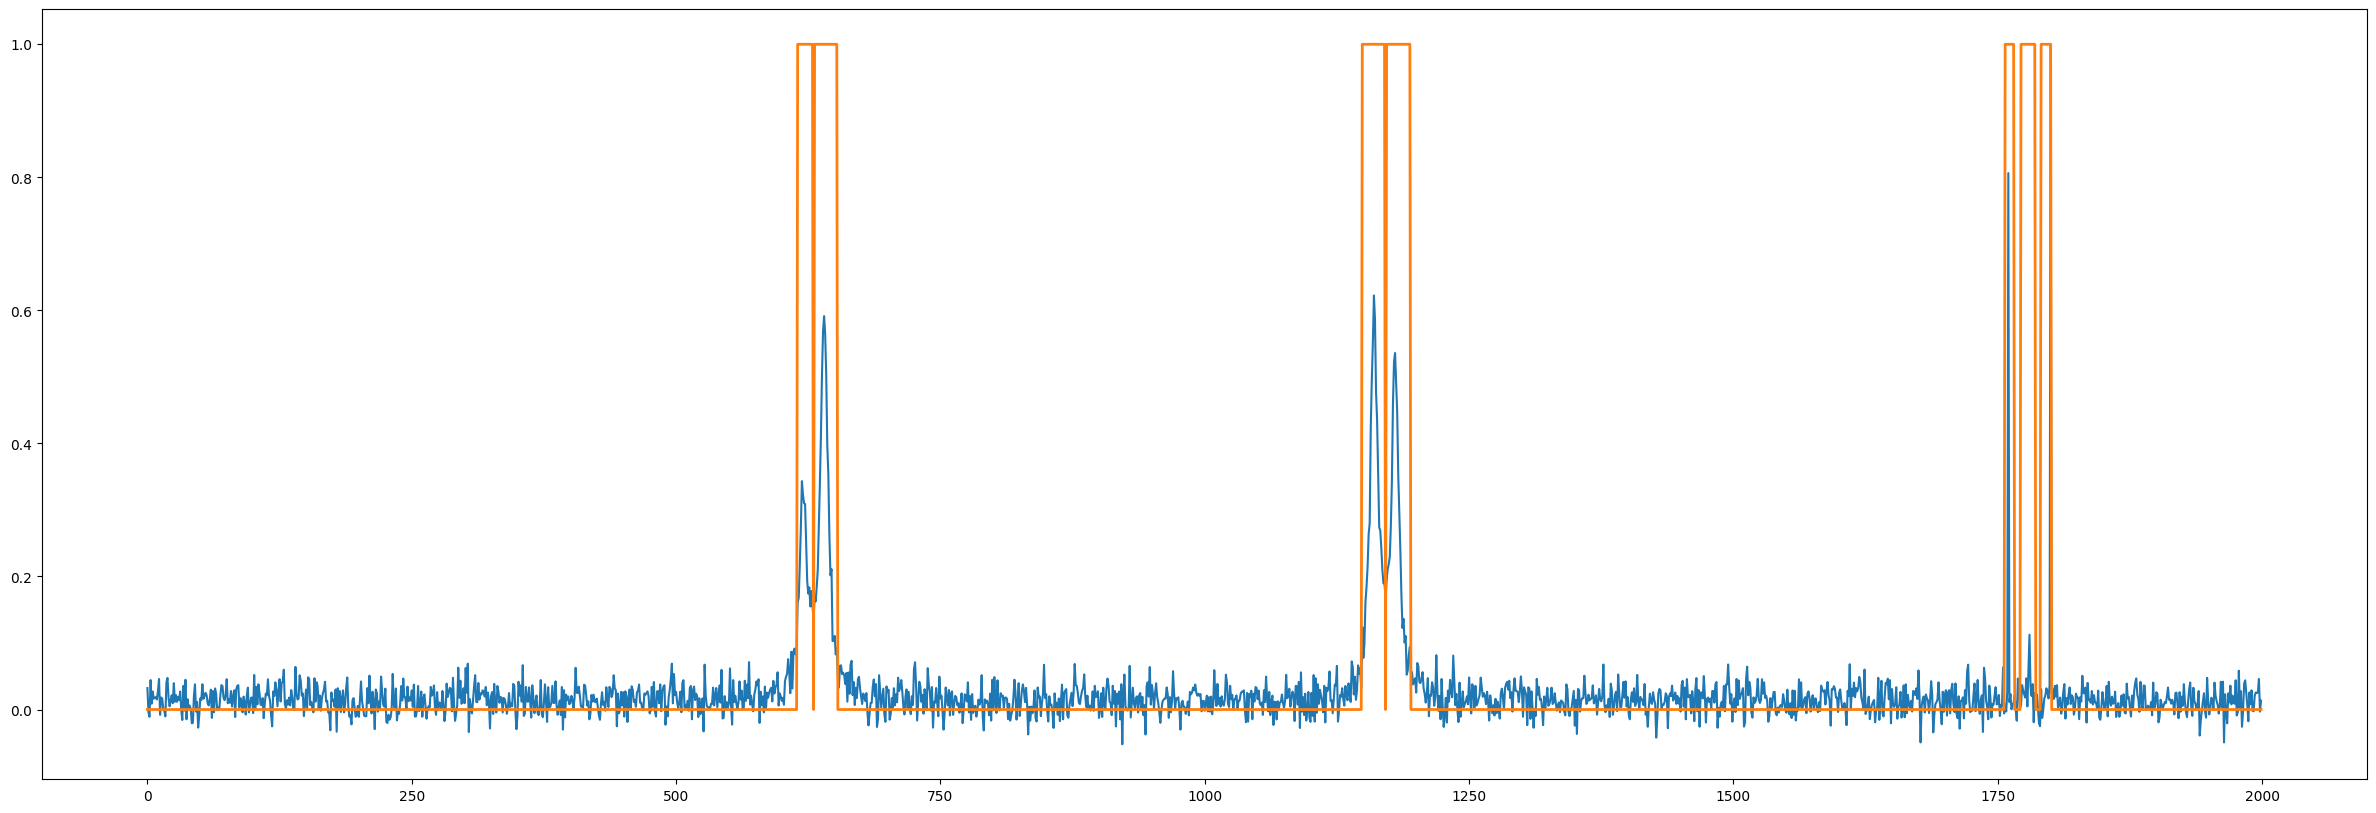

In [789]:
new_map= process_blocks(map, noisy_sgn, threshold_noise, buff_size=10)
plt.figure(figsize=(30,10))

plt.plot(np.real(noisy_sgn)/np.max(np.real(noisy_sgn)))
plt.plot(new_map,linewidth=2)
# plt.axvline(x=386-250, color='r', linestyle='--')
# plt.axvline(x=389-250, color='r', linestyle='--')
# # plt.plot(map,linewidth=2)

plt.show()

In [828]:
# extraction block info 
def BlockInfo(map):
    map0 = np.copy(new_map)
    ind = np.where(map0 == 1)[0]
    cons = consecutive(ind, stepsize=1)  # it contains our box in which should be the signal 

    BlockInfo = []
    for BlockNum in range(len(cons)): 
        BlockInfo.append({
            'Start' :  cons[BlockNum][0], 'End' : cons[BlockNum][-1]
        })
        
    return BlockInfo

In [791]:
block_info = BlockInfo(new_map)
block_info

[{'Start': 615, 'End': 629},
 {'Start': 631, 'End': 652},
 {'Start': 1149, 'End': 1170},
 {'Start': 1172, 'End': 1194},
 {'Start': 1757, 'End': 1765},
 {'Start': 1772, 'End': 1785},
 {'Start': 1791, 'End': 1800}]

In [814]:
#!/usr/bin/env python3
# −*− coding:utf-8 −*−

import numpy as np
from scipy.linalg import svd


class Denoiser(object):
    '''
    A class for smoothing a noisy, real-valued data sequence by means of SVD of a partial circulant matrix.
    -----
    Attributes:
        mode: str
            Code running mode: "layman" or "expert".
            In the "layman" mode, the code autonomously tries to find the optimal denoised sequence.
            In the "expert" mode, a user has full control over it.
        s: 1D array of floats
            Singular values ordered decreasingly.
        U: 2D array of floats
            A set of left singular vectors as the columns.
        r: int
            Rank of the approximating matrix of the constructed partial circulant matrix from the sequence.
    '''

    def __init__(self, mode="layman"):
        '''
        Class initialization.
        -----
        Arguments:
            mode: str
                Denoising mode. To be selected from ["layman", "expert"]. Default is "layman".
                While "layman" grants the code autonomy, "expert" allows a user to experiment.
        -----
        Raises:
            ValueError
                If mode is neither "layman" nor "expert".
        '''
        self._method = {"layman": self._denoise_for_layman, "expert": self._denoise_for_expert}
        if mode not in self._method:
            raise ValueError("unknown mode '{:s}'!".format(mode))
        self.mode = mode

    def _embed(self, x, m):
        '''
        Embed a 1D array into a 2D partial circulant matrix by cyclic left-shift.
        -----
        Arguments:
            x: 1D array of floats
                Input array.
            m: int
                Number of rows of the constructed matrix.
        -----
        Returns:
            X: 2D array of floats
                Constructed partial circulant matrix.
        '''
        x_ext = np.hstack((x, x[:m-1]))
        shape = (m, x.size)
        strides = (x_ext.strides[0], x_ext.strides[0])
        X = np.lib.stride_tricks.as_strided(x_ext, shape, strides)
        return X

    def _reduce(self, A):
        '''
        Reduce a 2D matrix to a 1D array by cyclic anti-diagonal average.
        -----
        Arguments:
            A: 2D array of floats
                Input matrix.
        -----
        Returns:
            a: 1D array of floats
                Output array.
        '''
        m = A.shape[0]
        A_ext = np.hstack((A[:,-m+1:], A))
        strides = (A_ext.strides[0]-A_ext.strides[1], A_ext.strides[1])
        a = np.mean(np.lib.stride_tricks.as_strided(A_ext[:,m-1:], A.shape, strides), axis=0)
        return a

    def _denoise_for_expert(self, sequence, layer, gap, rank):
        '''
        Smooth a noisy sequence by means of low-rank approximation of its corresponding partial circulant matrix.
        -----
        Arguments:
            sequence: 1D array of floats
                Data sequence to be denoised.
            layer: int
                Number of leading rows selected from the matrix.
            gap: float
                Gap between the data levels on the left and right ends of the sequence.
                A positive value means the right level is higher.
            rank: int
                Rank of the approximating matrix.
        -----
        Returns:
            denoised: 1D array of floats
                Smoothed sequence after denoise.
        -----
        Raises:
            AssertionError
                If condition 1 <= rank <= layer <= sequence.size cannot be fulfilled.
        '''
        assert 1 <= rank <= layer <= sequence.size
        self.r = rank
        # linear trend to be deducted
        trend = np.linspace(0, gap, sequence.size)
        X = self._embed(sequence-trend, layer)
        # singular value decomposition
        self.U, self.s, Vh = svd(X, full_matrices=False, overwrite_a=True, check_finite=False)
        # low-rank approximation
        A = self.U[:,:self.r] @ np.diag(self.s[:self.r]) @ Vh[:self.r]
        denoised = self._reduce(A) + trend
        return denoised

    def _cross_validate(self, x, m):
        '''
        Check if the gap of boundary levels of the detrended sequence is within the estimated noise strength.
        -----
        Arguments:
            x: 1D array of floats
                Input array.
            m: int
                Number of rows of the constructed matrix.
        -----
        Returns:
            valid: bool
                Result of cross validation. True means the detrending procedure is valid.
        '''
        X = self._embed(x, m)
        self.U, self.s, self._Vh = svd(X, full_matrices=False, overwrite_a=True, check_finite=False)
        # Search for noise components using the normalized mean total variation of the left singular vectors as an indicator.
        # The procedure runs in batch of every 10 singular vectors.
        self.r = 0
        while True:
            U_sub = self.U[:,self.r:self.r+10]
            NMTV = np.mean(np.abs(np.diff(U_sub,axis=0)), axis=0) / (np.amax(U_sub,axis=0) - np.amin(U_sub,axis=0))
            try:
                # the threshold of 10% can in most cases discriminate noise components
                self.r += np.argwhere(NMTV > .1)[0,0]
                break
            except IndexError:
                self.r += 10
        # estimate the noise strength, while r marks the first noise component
        noise_stdev = np.sqrt(np.sum(self.s[self.r:]**2) / X.size)
        # estimate the gap of boundary levels after detrend
        gap = np.abs(x[-self._k:].mean()-x[:self._k].mean())
        valid = gap < noise_stdev
        return valid

    def _denoise_for_layman(self, sequence, layer):
        '''
        Similar to the "expert" method, except that denoising parameters are optimized autonomously.
        -----
        Arguments:
            sequence: 1D array of floats
                Data sequence to be denoised.
            layer: int
                Number of leading rows selected from the corresponding circulant matrix.
        -----
        Returns:
            denoised: 1D array of floats
                Smoothed sequence after denoise.
        -----
        Raises:
            AssertionError
                If condition 1 <= layer <= sequence.size cannot be fulfilled.
        '''
        assert 1 <= layer <= sequence.size
        # The code takes the mean of a few neighboring data to estimate the boundary levels of the sequence.
        # By default, this number is 11.
        self._k = 11
        # Initially, the code assumes no linear inclination.
        trend = np.zeros_like(sequence)
        # Iterate over the averaging length.
        # In the worst case, iteration must terminate when it is 1.
        while not self._cross_validate(sequence-trend, layer):
            self._k -= 2
            trend = np.linspace(0, sequence[-self._k:].mean()-sequence[:self._k].mean(), sequence.size)
        # low-rank approximation by using only signal components
        A = self.U[:,:self.r] @ np.diag(self.s[:self.r]) @ self._Vh[:self.r]
        denoised = self._reduce(A) + trend
        return denoised

    def denoise(self, *args, **kwargs):
        '''
        User interface method.
        It will reference to different denoising methods ad hoc under the fixed name.
        '''
        return self._method[self.mode](*args, **kwargs)

In [803]:
def DenoiseNoise(signal, InfoBlock): 
    temp = []
    noise = []
    length_patch = []

    for NumBlock in range(len(InfoBlock)): 
        temp =[]
        if NumBlock == 1: 
            noise = signal[0:(InfoBlock[NumBlock]['Start']-1)] 
            length_patch = len(noise)

        elif NumBlock == len(InfoBlock): 
            temp = signal[(InfoBlock[NumBlock]['End']+1):-1] 
            noise = np.concatenate((noise, temp))
            length = np.concatenate((length_patch))
        else: 
            temp = signal[(InfoBlock[NumBlock-1]['End']+1):(InfoBlock[NumBlock]['Start']-1)]
            noise= np.concatenate((noise, temp))
    
    denoised = denoiser.denoise(noise, 100)
            
    return denoised

In [ ]:
# recomposing signal 
def SignalReconstruction(signal, InfoBlock, noisyArray): 
    for NumBlock in range(len(InfoBlock)): 
        if NumBlock == 1: 
            temp_array = np.concatenate(
                denoised[0:(InfoBlock[NumBlock]['Start']-1)], 
                signal[(InfoBlock[NumBlock]['Start']):(InfoBlock[NumBlock]['End'])])
        elif NumBlock == len(InfoBlock): 
            ... 
        else: 
            temp= np.concatenate(
                denoised[(InfoBlock[NumBlock-1]['End']+1):(InfoBlock[NumBlock]['Start'])-1], 
                signal[(InfoBlock[NumBlock-1]['End']):(InfoBlock[NumBlock]['Start'])])



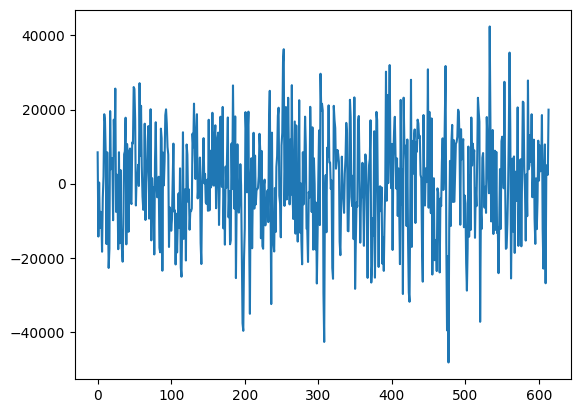

In [777]:
noise = signal[0:(block_info[0]['Start']-1)] 
temp = signal[(block_info[0]['End']+1):(block_info[1]['Start']-1)]
noise2= np.concatenate((noise,temp))
plt.plot(noise2)

In [762]:
array1 = np.array([1,2,3])
array2 = np.array([4, 5, 6])
concatenated_array = np.concatenate((array1, array2))
print(concatenated_array)

[1 2 3 4 5 6]


In [387]:
# we reconsider all blocks individually and for each peak within the block derive the FWHM (full width half maximum)
map0 = np.copy(new_map)
ind = np.where(map0 == 1)[0]
cons = consecutive(ind, stepsize=1)  # it contains our box in which should be the signal 
r = np.zeros(len(cons))



for ii in range(len(cons)):
    startblock = cons[ii][0] 
    endblock = cons[ii][-1]

    if endblock-startblock <= 3: 
        startblock = startblock-1
        endblock = endblock+1

    block_sgn = noisy_sgn[startblock:endblock]              # signal inside the block


    from scipy.interpolate import UnivariateSpline

    def make_norm_dist(x, mean, sd):
        return 1.0/(sd*np.sqrt(2*np.pi))*np.exp(-(x - mean)**2/(2*sd**2))


    x = np.linspace(startblock, endblock, len(block_sgn))

    spline = UnivariateSpline(x, block_sgn-np.max(block_sgn)/2, s=0)
    temp = spline.roots()
    if len(temp) == 1:
        r[ii] = 1
    else: 
        r1, r2 = spline.roots()
        r[ii] = r2-r1


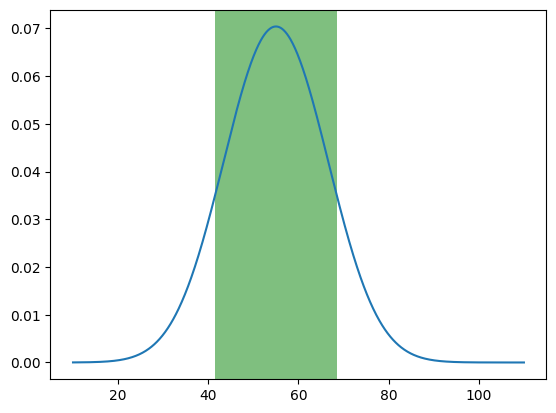

In [429]:
import numpy as np
from scipy.interpolate import UnivariateSpline

def make_norm_dist(x, mean, sd):
    return 1.0/(sd*np.sqrt(2*np.pi))*np.exp(-(x - mean)**2/(2*sd**2))

x = np.linspace(10, 110, 1000)
green = make_norm_dist(x, 50, 10)
pink = make_norm_dist(x, 60, 10)

blue = green + pink   

# create a spline of x and blue-np.max(blue)/2 
spline = UnivariateSpline(x, blue-np.max(blue)/2, s=0)
r1, r2 = spline.roots() # find the roots

import pylab as pl
pl.plot(x, blue)
pl.axvspan(r1, r2, facecolor='g', alpha=0.5)
pl.show()

In [352]:
# parameter extraction 

f0 = np.zeros(len(PeakInfo))
sample_peak =[PeakInfo[i]["Index"] for i in range(len(PeakInfo))]

f0 = freqs[sample_peak]
W12_sample  = [PeakInfo[i]["PeakWidth"] for i in range(len(PeakInfo))]

temp = [len(freqs)- W12_sample[i] for i in range(len(W12_sample))]
W12 =  [freqs[-1]-temp[i] for i in range(len(temp))]
# T2 =[1 / (2 * np.pi * PeakInfo[i]["PeakWidth"]) for i in range(len(PeakInfo))]

1.0106009781482044

TEST WITH REAL SIGNAL 

In [818]:
import scipy.io
directory ='C:/Users/chiar/Documents/tesi IBEC doc/script/FinalFolder/'
signal = scipy.io.loadmat(directory+ 'signal.mat')
signal = signal['signal'][0] 
signal

array([  8448.25673256, -14292.80231621,    300.91021087, ...,
        17851.7797705 , -17925.80747626,  -9516.66306558])

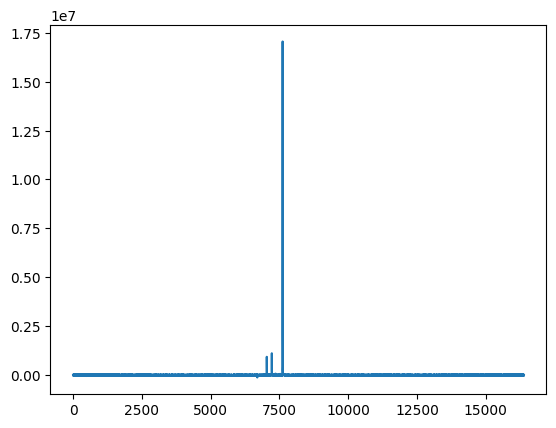

In [819]:
plt.plot(signal)

In [820]:
regionSgn, threshold_noise =  signal_region(signal,6)
map1 = find_peak_region(signal,threshold_noise)

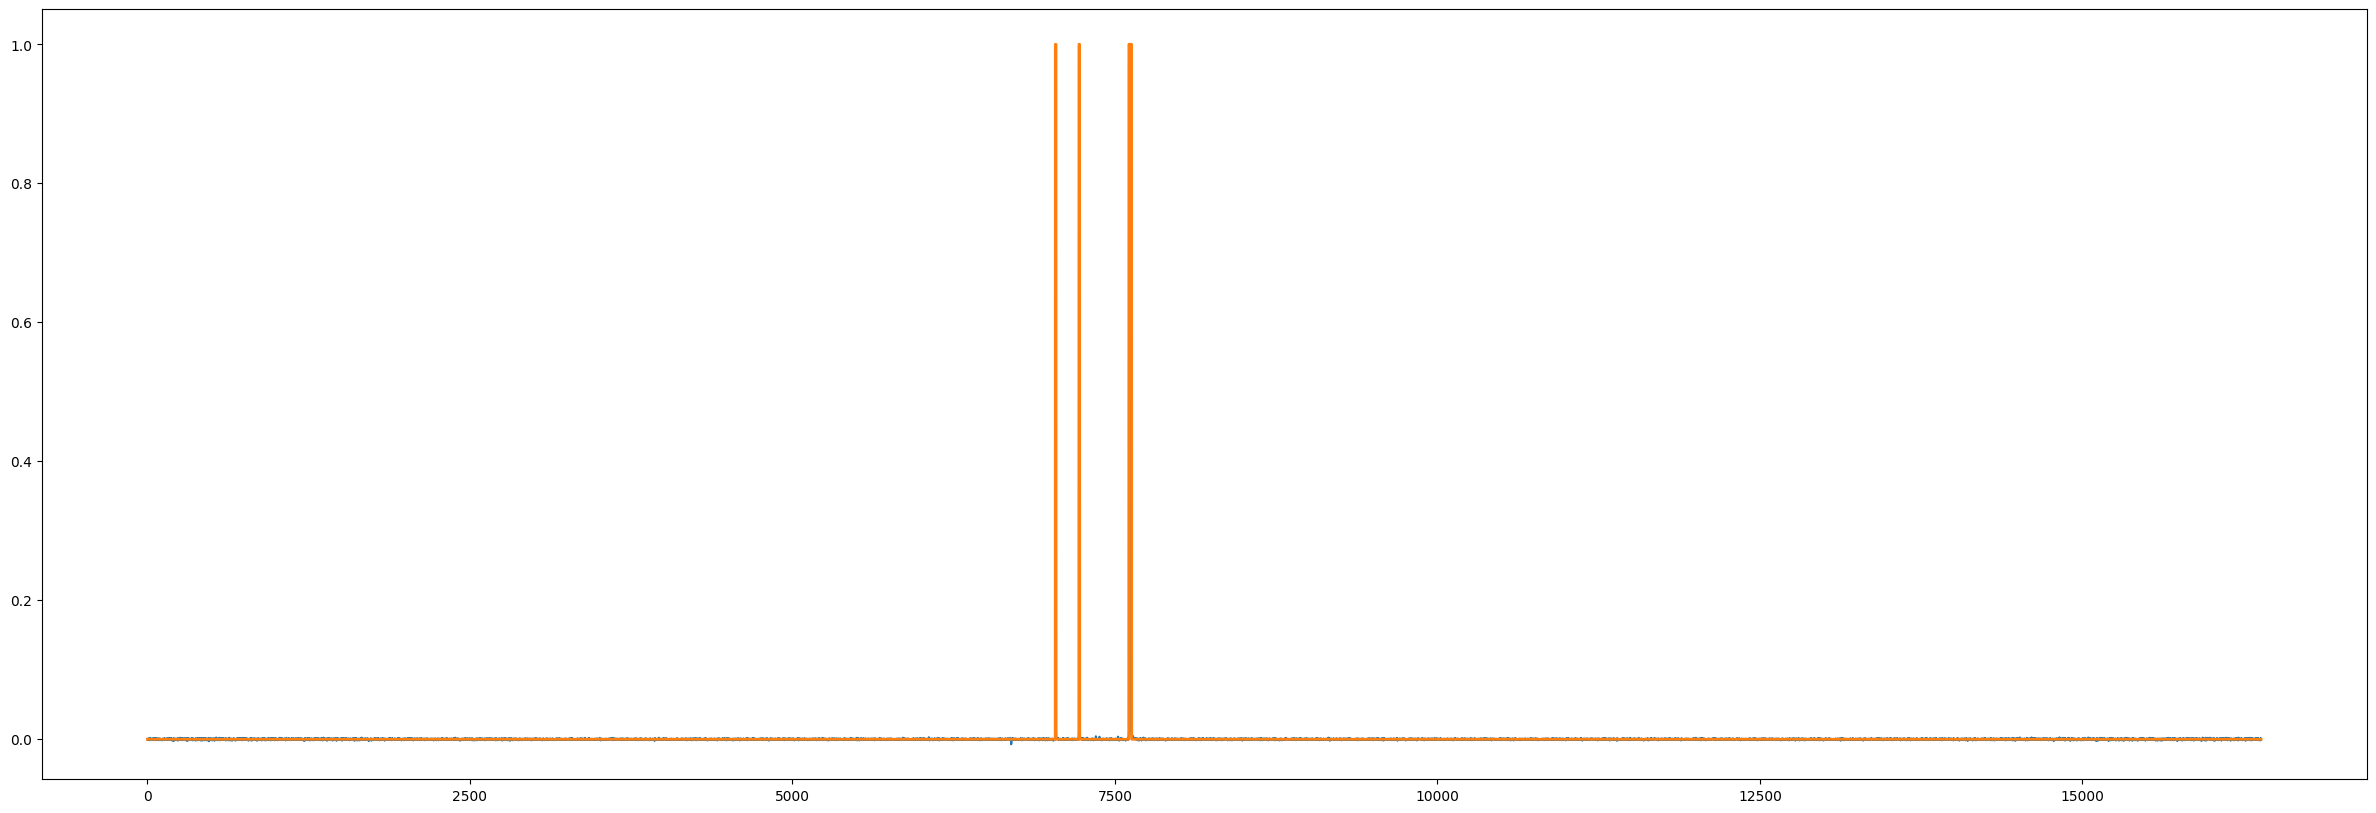

In [821]:
plt.figure(figsize=(30,10))

plt.plot(np.real(signal)/np.max(np.real(signal)))
plt.plot(map1,linewidth=2)

plt.show()

In [850]:
PeakInfo = analyze_peaks(signal, threshold_noise, distance=10)
PeakInfo 

[{'Start': 7038.0,
  'End': 7041.0,
  'Index': 7040,
  'Val': 934026.3089562769,
  'PeakWidth': 3},
 {'Start': 7221.0,
  'End': 7224.0,
  'Index': 7223,
  'Val': 1115123.3393488186,
  'PeakWidth': 3},
 {'Start': 7614.0,
  'End': 7617.0,
  'Index': 7616,
  'Val': 17052676.091531526,
  'PeakWidth': 3}]

In [853]:
new_map1= process_blocks(map1, signal, threshold_noise, buff_size=5)
cons(new_map1)

TypeError: 'list' object is not callable

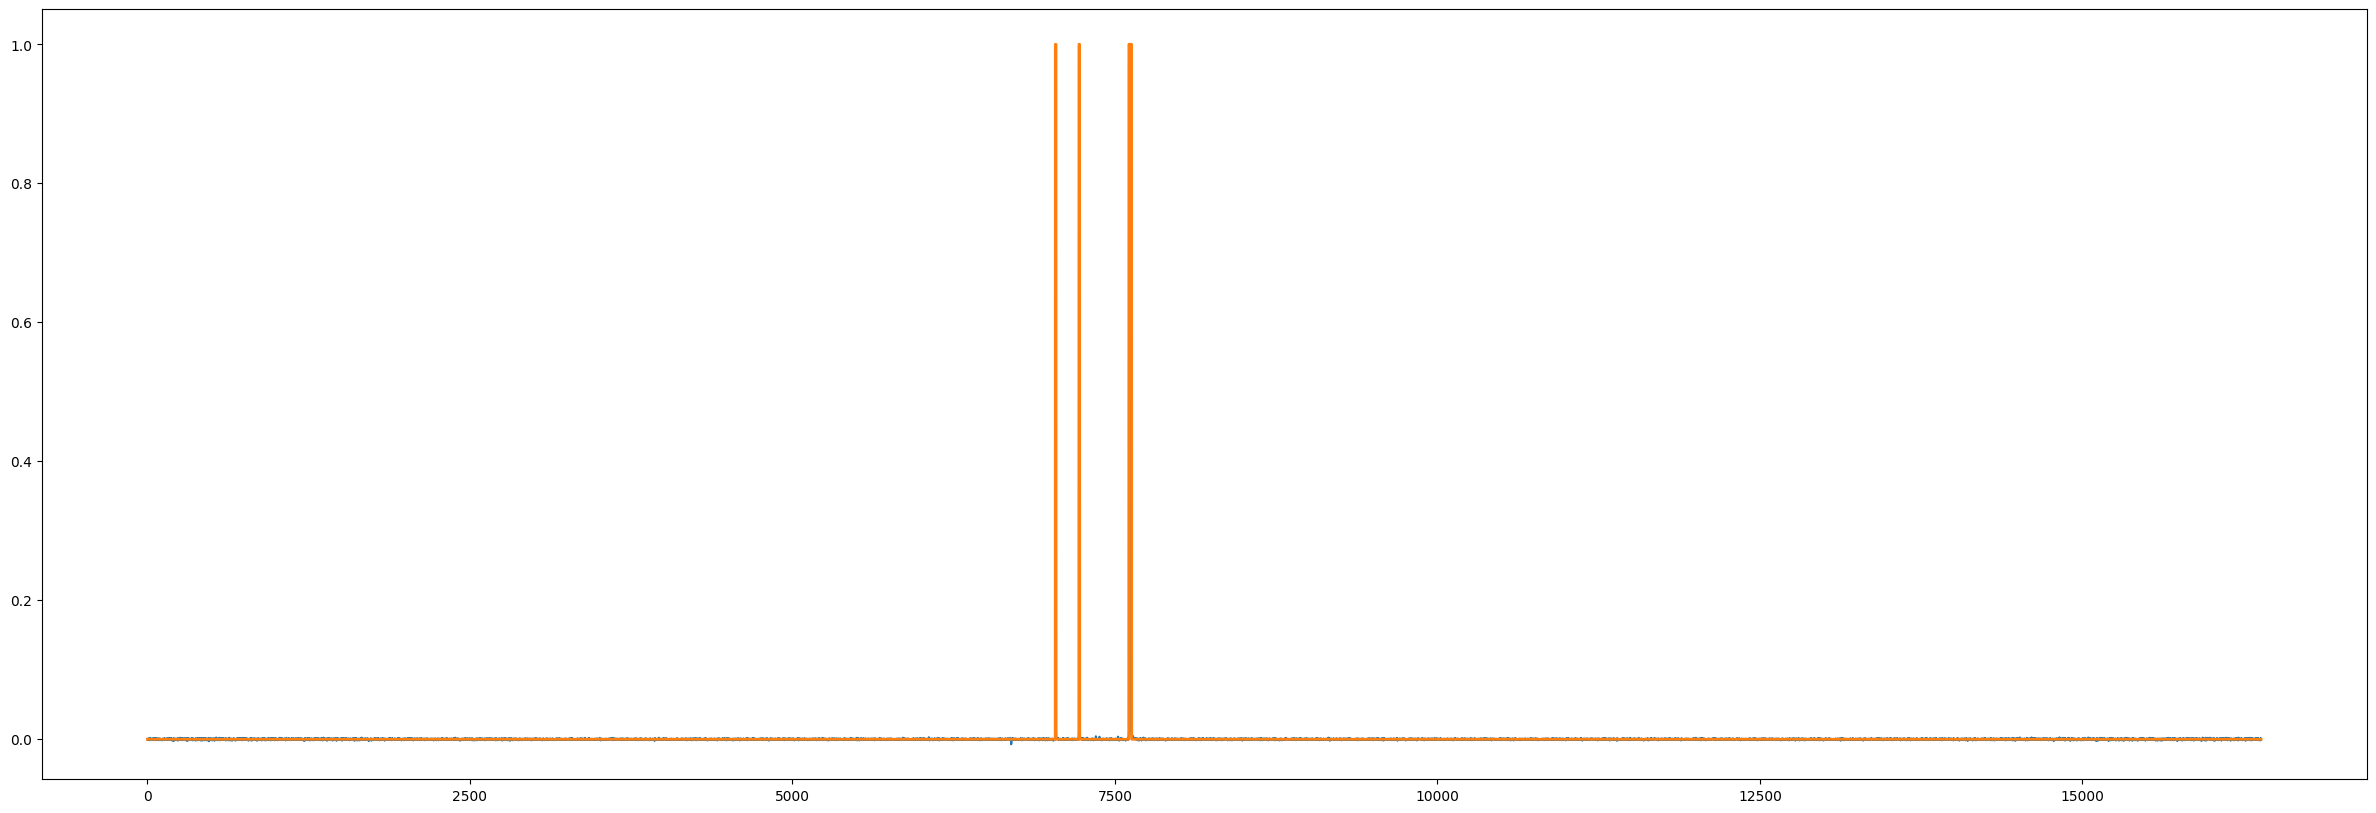

In [826]:
plt.figure(figsize=(30,10))

plt.plot(np.real(signal)/np.max(np.real(signal)))
plt.plot(new_map1,linewidth=2)

plt.show()

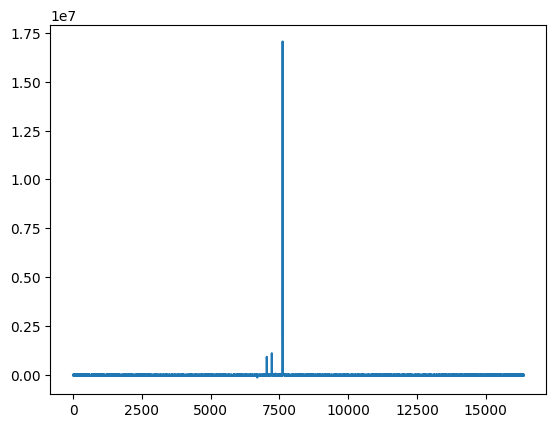

In [836]:
InfoBlock = BlockInfo(new_map1)
noise = np.copy(signal)
for NumBlock in range(len(InfoBlock)):
    noise[(InfoBlock[NumBlock]['Start']):(InfoBlock[NumBlock]['End'])] = 0
        
plt.plot(noise)

In [832]:
InfoBlock

[{'Start': 615, 'End': 629},
 {'Start': 631, 'End': 652},
 {'Start': 1149, 'End': 1170},
 {'Start': 1172, 'End': 1194},
 {'Start': 1757, 'End': 1765},
 {'Start': 1772, 'End': 1785},
 {'Start': 1791, 'End': 1800}]

In [833]:
InfoBlock[0]['Start']-1

614

In [844]:

noise[(InfoBlock[3]['Start']):(InfoBlock[3]['End'])] = 0

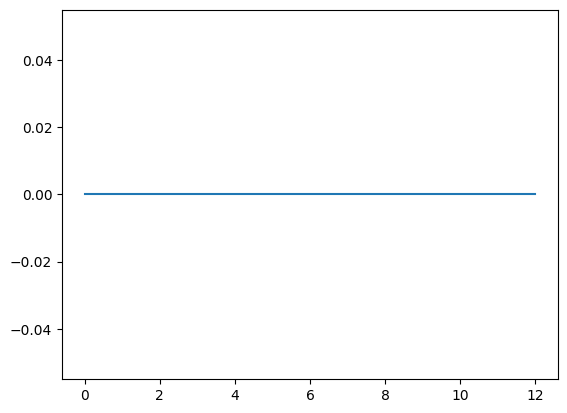

In [848]:
plt.plot(noise)


In [690]:
gaussian_filter1d(block_sgn, 1)

map0 = np.copy(new_map1)
ind = np.where(map0 == 1)[0]
cons = consecutive(ind, stepsize=1)  # it contains our box in which should be the signal 

BlockInfo = []
for BlockNum in range(len(cons)): 
    BlockInfo.append({
        'Start' :  cons[BlockNum][0], 'End' : cons[BlockNum][-1]
    })

BlockInfo
y = np.zeros(len(signal))
for BlockNum in range(len(cons)):
    new_signal = gaussian_filter1d(signal(BlockInfo[BlockNum]['Start']:BlockInfo[BlockNum]['End']),1 )
    y


[{'Start': 7038, 'End': 7043},
 {'Start': 7221, 'End': 7226},
 {'Start': 7608, 'End': 7629}]

Denoising

Selection best threshold

In [448]:
# extraction smooth signal 
smooth_sgn = gaussian_filter1d(noisy_sgn, 1)

# fourier transformation in order to obtain FID signal 

def calculate_fid_signal(spectrum):
    # Apply inverse Fourier transform to the spectrum
    fid_signal = rfft(spectrum)
    return fid_signal

# Example usage:
# Assuming `spectrum` is your spectrum data
fid_signal = calculate_fid_signal(smooth_sgn)
# plt.plot(np.real(fid_signal))

# application hankel matrix transformation 
from scipy.linalg import hankel


# Creazione della matrice di Hankel
def hankel_matrix(signal):
    n = int(len(signal)/2)
    m = len(signal)
    hankel = np.zeros((m - n + 1, n))
    for i in range(m - n + 1):
        hankel[i] = signal[i:i + n]
    return hankel


# Creazione della matrice di Hankel
hankel = hankel_matrix(fid_signal)

# Calcolo del rank
rank = np.linalg.matrix_rank(hankel)

print("Rank della matrice di Hankel:", rank)

# rank extraction 

# threshol definition 

# check if number of peak is equal to the rank 

# if they are different, update the threshold 

C:\Users\chiar\AppData\Local\Temp\ipykernel_39924\244232570.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
  hankel[i] = signal[i:i + n]


Rank della matrice di Hankel: 500


C:\Users\chiar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\chiar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


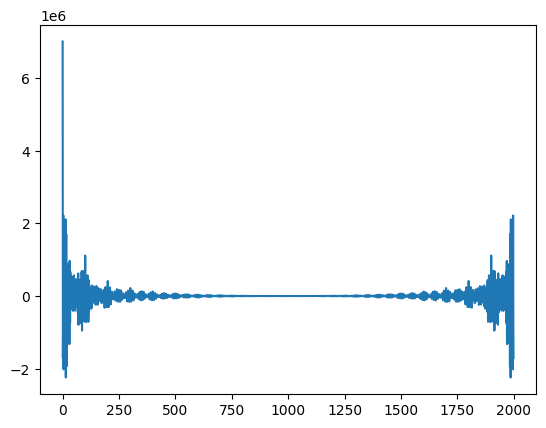

In [436]:
plt.plot(smooth_fid)

In [136]:
def process_blocks(map, noisy_sgn, threshold_noise, buff_size):
    map0 = np.copy(map)
    ind = np.where(map0 == 1)[0]
    cons = consecutive(ind, stepsize=1)  # it contains our box in which should be the signal 

    for ii in range(len(cons)): 
        startblock = cons[ii][0] - buff_size
        endblock = cons[ii][-1] + buff_size

        blockInfo = analyze_peaks(noisy_sgn[startblock:endblock], threshold_noise, distance=None)
        second_dev = np.zeros(len(cons))
        # check how many peaks there are inside one block 
        if len(blockInfo) != 1: 
            num_peak_block = len(blockInfo)                         # number peaks in the block 
            num_infl_point = 2*num_peak_block                       # number of inflection point 
            block_sgn = noisy_sgn[startblock:endblock]              # signal inside the block 

            second_dev = base_deriv(base_deriv(block_sgn)) 
            infls = np.where(base_deriv(np.sign(second_dev)))[0]    # inflection point in the considering block
            ip = np.zeros(num_peak_block-1)                         # expected number of inflection point between the peaks
            
            k = 0
            # find the minumom point of the signal inside the block between two inflection point 
            for j in range (1,num_infl_point-2): 
                if j != (num_infl_point-2): 
                    valip = min(block_sgn[infls[j]:infls[j+1]])
                    # ip[k] = np.where(block_sgn == valip) + startblock
                    # # ip[k] = idx[0] + startblock
                    # k +=1
            
            # res = True in (ele > threshold_noise for ele in valip) 

            if  valip<threshold_noise: 
                # All inflection points are below the threshold
                for NumPeak in range(0, len(blockInfo) - 1): 
                    if NumPeak != len(blockInfo):
                        start_noise = blockInfo[NumPeak]['End'] + startblock + 1
                        end_noise = blockInfo[NumPeak + 1]['Start'] + startblock - 1

                        start_noise = int(start_noise)
                        end_noise = int(end_noise)

                        start_signal = int(blockInfo[NumPeak]['Start']+startblock)
                        end_signal = int(blockInfo[NumPeak]['End']+startblock)

                        map0[start_noise:end_noise] = 0
                        map0[start_signal:end_signal] = 1

            # else: 
                # Some inflection points are above or equal to the threshold,  so don't apply the function 


               
    return map0


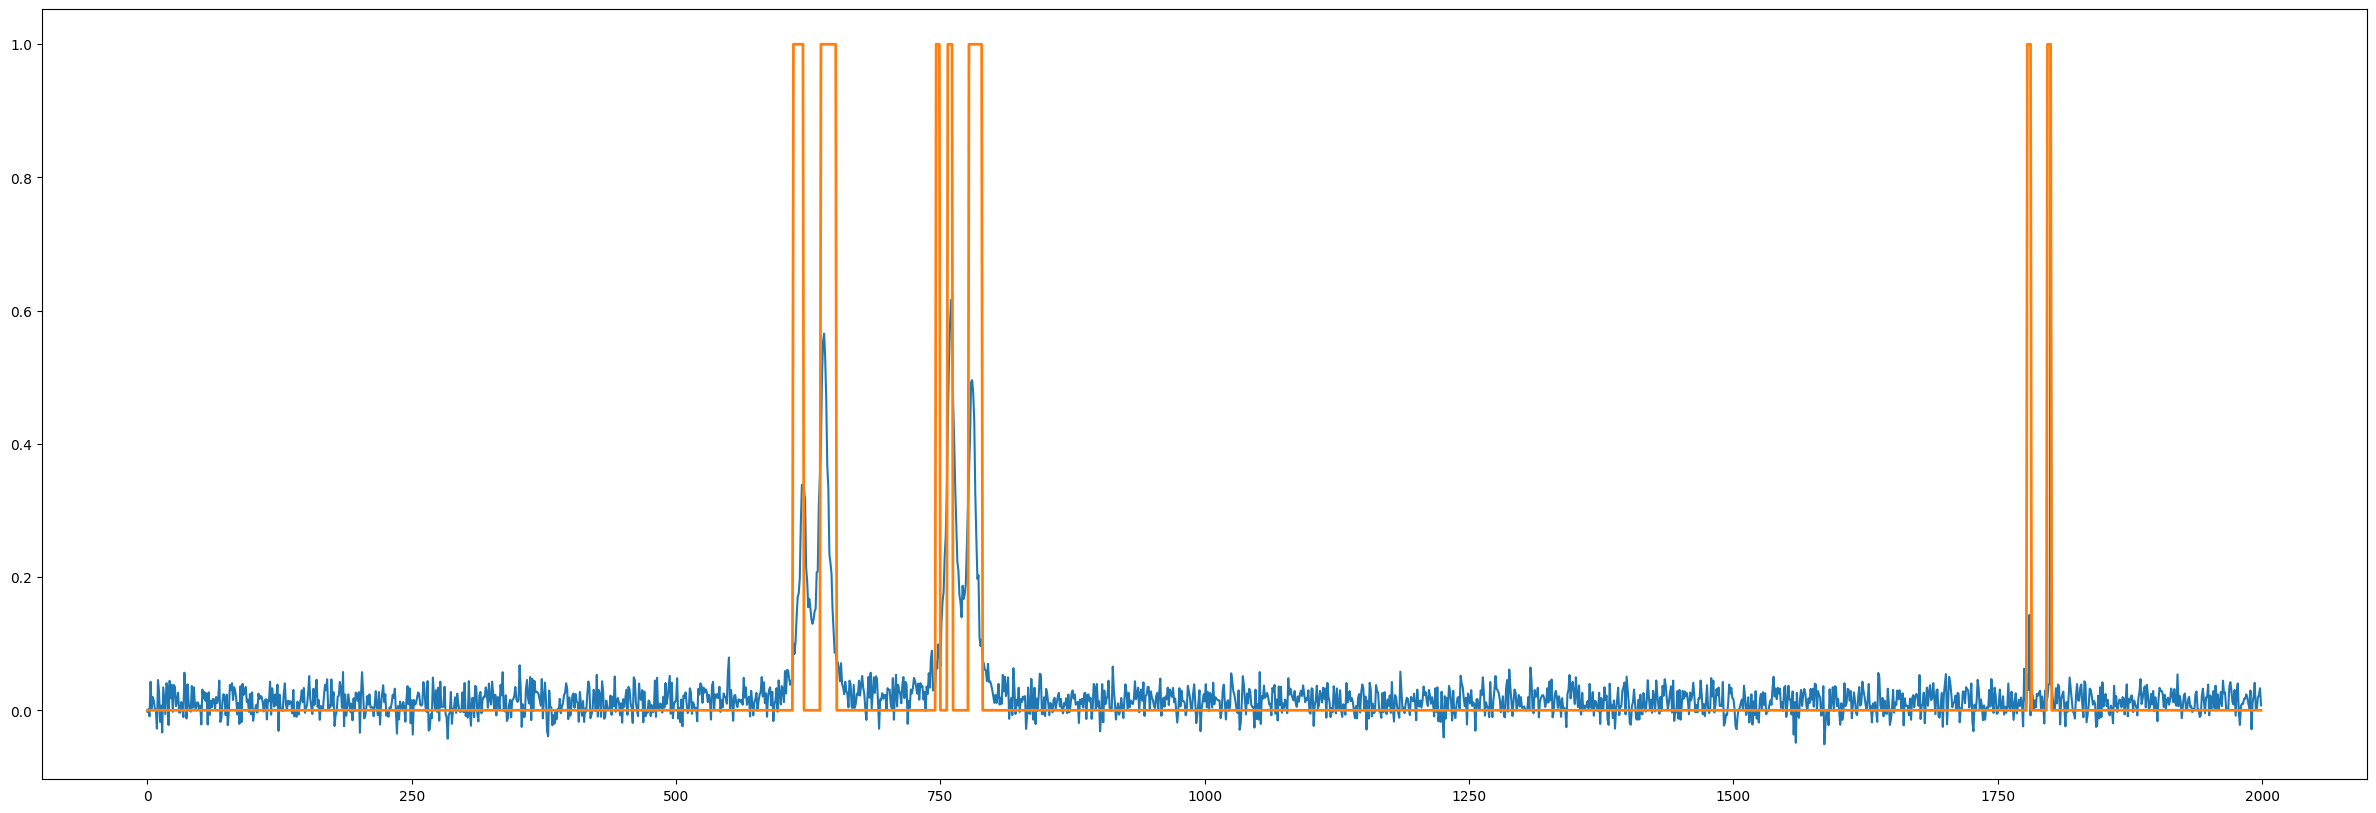

In [137]:
new_map= process_blocks(map, noisy_sgn, threshold_noise, buff_size=10)

plt.figure(figsize=(30,10))

plt.plot(np.real(noisy_sgn)/np.max(np.real(noisy_sgn)))
plt.plot(new_map,linewidth=2)
# plt.axvline(x=386-250, color='r', linestyle='--')
# plt.axvline(x=389-250, color='r', linestyle='--')
# # plt.plot(map,linewidth=2)

plt.show()

array([119, 140], dtype=int64)

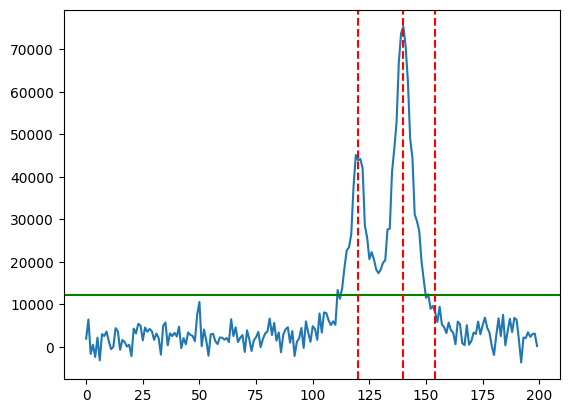

In [138]:
plt.plot(noisy_sgn[500:700])
plt.axhline(y=threshold_noise, color='g', linestyle='-', linewidth=1.5)
y = noisy_sgn[500:700]
locs, prop = find_peaks(y, height=threshold_noise, distance=10,prominence=True, width=True)
plt.axvline(x=120, color='r', linestyle='--')
plt.axvline(x=140, color='r', linestyle='--')
plt.axvline(x=154, color='r', linestyle='--')
locs

In [139]:
np_percentage = 25
dy = base_deriv(y)
np_sample = round(len(dy) * (np_percentage / 100))
    
# Calculate mean and standard deviation of noise
mean_noise = np.mean(np.abs(np.real(dy[:np_sample])))
std_noise = np.std(np.real(dy[:np_sample]))
    
# Threshold for noise

threshold_noise2 = mean_noise + 4 * std_noise
threshold_noise2

1969.4066015577453

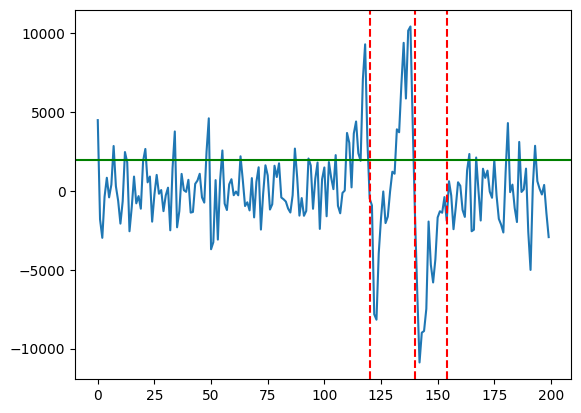

In [140]:
plt.plot(np.gradient(y))
plt.axhline(y=threshold_noise2, color='g', linestyle='-', linewidth=1.5)
plt.axvline(x=120, color='r', linestyle='--')
plt.axvline(x=140, color='r', linestyle='--')
plt.axvline(x=154, color='r', linestyle='--')

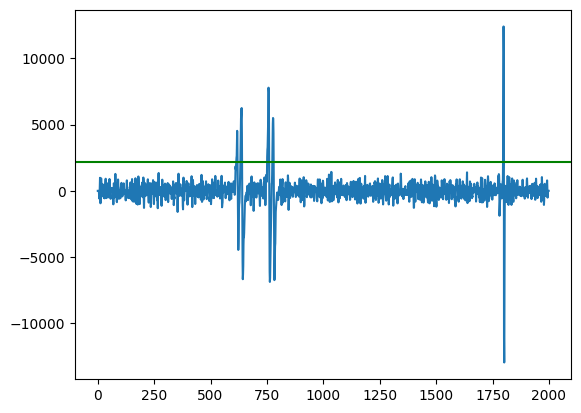

In [141]:
# Percentage of noise
data = base_deriv(noisy_sgn)
np_percentage = 10
np_sample = round(len(data) * (np_percentage / 100))
    
# Calculate mean and standard deviation of noise
mean_noise = np.mean(np.abs(np.real(data[:np_sample])))
std_noise = np.std(np.real(data[:np_sample]))
 
# Threshold for noise
threshold_noise_diff = mean_noise + 4 * std_noise
threshold_noise_diff

plt.plot(data)
plt.axhline(y=threshold_noise_diff, color='g', linestyle='-', linewidth=1.5)


In [142]:
# correct artefact due to overlapping 
def overlapping_check (noisy_sgn, map0):
    data = base_deriv(noisy_sgn)
    np_percentage = 10
    np_sample = round(len(data) * (np_percentage / 100))
        
    # Calculate mean and standard deviation of noise
    mean_noise = np.mean(np.abs(np.real(data[:np_sample])))
    std_noise = np.std(np.real(data[:np_sample]))
 
    # Threshold for noise
    threshold_noise_diff = mean_noise + 4 * std_noise
    
    buff_size =10

    map0 = np.copy(map)
    ind = np.where(map0 == 1)[0]
    cons = consecutive(ind, stepsize=1)  # it contains our box in which should be the signal 

    for ii in range(len(cons)): 
        startblock = cons[ii][0] - buff_size
        endblock = cons[ii][-1] + buff_size

        blockInfo = analyze_peaks(data[startblock:endblock], threshold_noise_diff, distance=None)
    

    pks = prop['peak_heights']
    p = prop['prominences']
    peakWidth1 = prop['width_heights']
    
    # compute starting and ending points
    startpoint = np.zeros_like(pks)
    endpoint = np.zeros_like(pks)

    for ii in range(len(pks)):
        # plt.plot([locs[ii] + peakWidth1[ii]*(-0.5), locs[ii] + peakWidth1[ii]*0.5], [pks[ii] - p[ii]/2, pks[ii] - p[ii]/2], 'y')
        sp = np.where((x < locs[ii]) & (dy_dx > 0))
        if np.shape(sp) == 0:
            sp = 0
        else:
            sp=sp[0][-1]
        startpoint[ii] = sp

        ep = np.where((x > locs[ii]) & (dy_dx >= 0))
        if np.shape(ep)==0:
            ep = len(x)
        else:
            ep=ep[0][0]
        endpoint[ii] = ep+1

        # plt.plot(x[int(startpoint[ii])], y[int(startpoint[ii])], 'og')
        # plt.plot(x[int(endpoint[ii])], y[int(endpoint[ii])], 'sr')
    
    # plt.tight_layout()
    # plt.show()
    # compute second type of width using ending and starting points
    PeakWidth2 = []
    PeakWidth2 = [x[int(endpoint[i])] - x[int(startpoint[i])] for i in range(len(endpoint))]
   

    # structure creation containing information about peaks
    PeakInfo = []
    for PeakNum in range(len(locs)):
        if np.shape(locs[PeakNum]) == 0:
            PeakInfo.append({
                'Start': 0, 'End': 0, 'Index': 0,
                'Val': 0, 'PeakWidth': 0
            })
        else:
            PeakInfo.append({
                'Start': startpoint[PeakNum], 'End': endpoint[PeakNum], 'Index': locs[PeakNum],
                'Val': pks[PeakNum], 'PeakWidth': PeakWidth2[PeakNum]
            })

    # filterPeak = [peak for peak in PeakInfo if (peak['End'] - peak['Start']) > 10]
    
    return PeakInfo
    return blockInfo

In [143]:
info = overlapping_check (noisy_sgn, map)
info

NameError: name 'dy_dx' is not defined

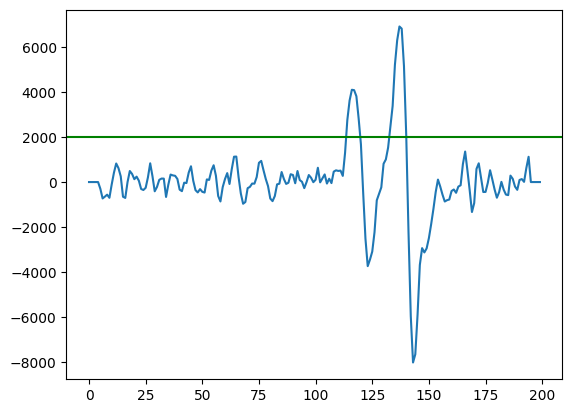

In [ ]:
plt.plot(base_deriv(y))
plt.axhline(y=threshold_noise_diff, color='g', linestyle='-', linewidth=1.5)

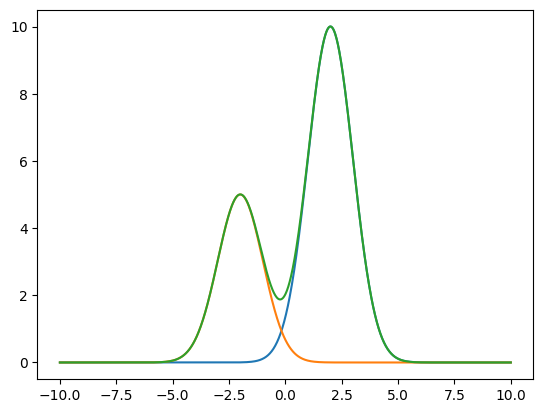

In [ ]:

# Create x values
x = np.linspace(-10, 10, 1000)

# Create two Gaussian peaks
peak1 = 10*np.exp(-(x - 2)**2 / (2 * 1**2))  # Gaussian centered at x=2
peak2 = 5*np.exp(-(x + 2)**2 / (2 * 1**2))  # Gaussian centered at x=-2

# Create overlapping peaks
overlapping_peaks = peak1 + peak2

# Plot the peaks
plt.plot(x, peak1, label='Peak 1')
plt.plot(x, peak2, label='Peak 2')
plt.plot(x, overlapping_peaks, label='Overlapping Peaks')

array([348, 443, 550, 648], dtype=int64)

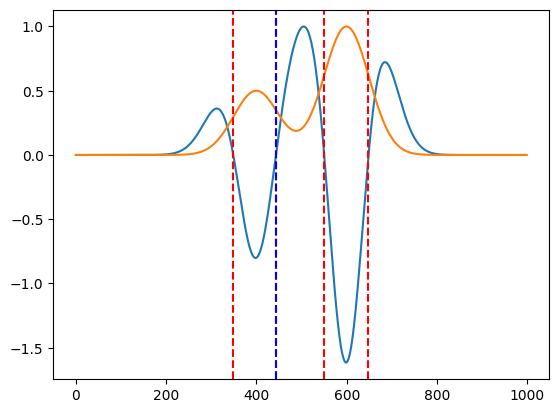

In [ ]:
second_dev = np.diff(np.diff(overlapping_peaks))
infls = np.where(np.diff(np.sign(second_dev)))[0]

plt.plot(second_dev/np.max(second_dev))
plt.plot(overlapping_peaks/np.max(overlapping_peaks), label='Overlapping Peaks')

plt.axvline(x=348, color='r', linestyle='--')
plt.axvline(x=443, color='r', linestyle='--')
plt.axvline(x=550, color='r', linestyle='--')
plt.axvline(x=648, color='r', linestyle='--')
plt.axvline(x=443, color='b', linestyle='--')

infls

In [ ]:
locs, prop = find_peaks(overlapping_peaks, height=2, distance=None,prominence=True, width=True)
num_peak = len(locs) 
num_ip = 2*num_peak 

second_dev = np.diff(np.diff(overlapping_peaks))
infls = np.where(np.diff(np.sign(second_dev)))[0]

# ip_Val, ip_Loc = max(second_dev[infls[1:2]])
import operator
value = max
index, value = max(enumerate(second_dev[infls[1]:infls[2]]), key=operator.itemgetter(1))
ip = np.where(second_dev == value)

valip = min(overlapping_peaks[infls[1]:infls[2]])
ip2 = np.where(overlapping_peaks == valip)

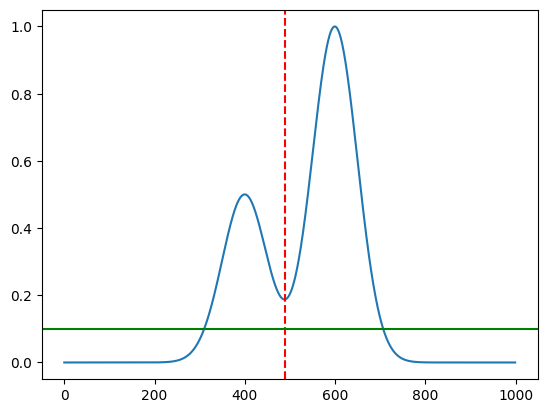

In [ ]:
plt.plot(overlapping_peaks/np.max(overlapping_peaks), label='Overlapping Peaks')
plt.axvline(x=ip2, color='r', linestyle='--')
plt.axhline(y=1/np.max(overlapping_peaks), color='g', linestyle='-', linewidth=1.5)

In [ ]:

all_below_threshold = all(overlapping_peaks[ip2] < 1)

if all_below_threshold:
    # Run subsequent operations here
    print("All inflection points are below the threshold. Running subsequent operations...")
else:
    print("Some inflection points are above or equal to the threshold. Subsequent operations will not be run.")

Some inflection points are above or equal to the threshold. Subsequent operations will not be run.


In [ ]:
def base_deriv(s0):
    """
    Function to determine signal derivative
    Uses equation 5 of Zorin et. al. Magn. Reson. Chem. 2017, 55, 738–746
    
    Parameters
    ----------
    s0  : ndarray
        The real component of a FFT array
    Returns
    -------
    deriv : ndarray
        The derivitive of the data, s0
    """
    deriv = np.zeros((len(s0)))
    for i in range(5,len(s0)-5):
        deriv[i] = (42*(s0[i] - s0[i-1]) + 48*(s0[i+1]-s0[i-2]) + 27*(s0[i+2]-s0[i-3]) + 8*(s0[i+3]-s0[i-4]) + s0[i+4]-s0[i-5])/512
    return deriv

In [ ]:
# Double check region with peaks 

def doublecheck_peak_region(noisy_signal, map, ind_over): 

     only_noise = []

     # map2 = np.copy(map)
     only_noise = []

     init_indx = np.where(map == 1)[0]
     cons_indx = consecutive(init_indx)

     # map = np.delete(map, cons_indx)
     num_peak = len(cons_indx)

     # start_signal = noisy_signal[0]
     
     for i in range(0, num_peak):
          if i == 0: 
               only_noise = noisy_signal[0:cons_indx[i][0]]
               
               # only_noise.append(noisy_signal[0:cons_indx[i][0]])
          else: 
               only_noise = np.hstack((only_noise, noisy_signal[cons_indx[i-1][-1]:cons_indx[i][0]]))
               #  only_noise.append(noisy_signal[cons_indx[i-1][1]:cons_indx[i][0]])

     stdNoiseDef = np.std(only_noise)
     meanNoiseDef = statistics.mean (only_noise) 
     thresholdDef =meanNoiseDef + 4 * stdNoiseDef

     # double check about the peaks make by only one point 
     ind_over = np.where(noisy_signal > thresholdDef)[0]
     cons = consecutive(ind_over,stepsize=1)
     peaks_with_dimension_one = [arr for arr in cons if arr.size == 1]


     
     map2 = find_peak_region(noisy_signal,thresholdDef)
     for i in range(0, len(peaks_with_dimension_one)): 
          map2[]
     
     return map2

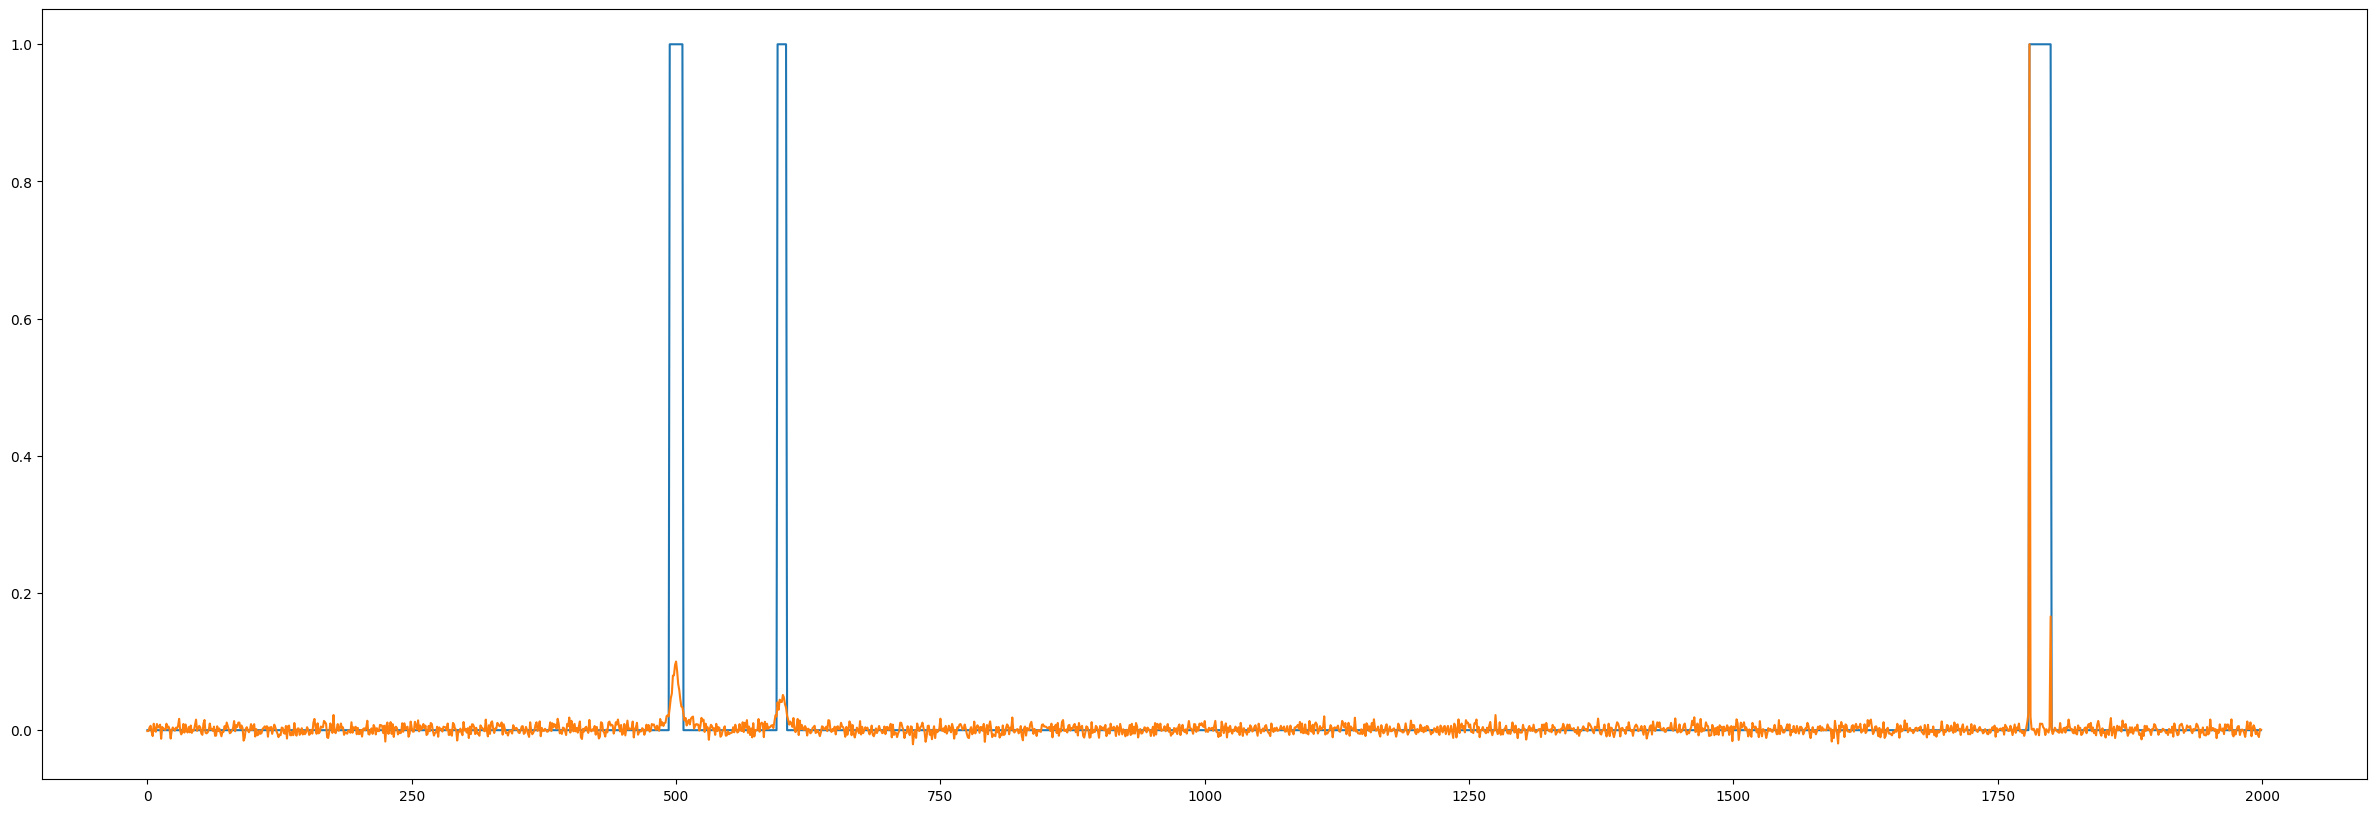

In [ ]:
mapDef = doublecheck_peak_region(noisy_sgn, map)
plt.figure(figsize=(30,10))
plt.plot(mapDef,linewidth=1.5)
plt.plot(np.real(noisy_sgn)/np.max(np.real(noisy_sgn)))
plt.show()


In [ ]:
def peak_indices(regions, buffer_size = 100, filter_size = 10):
    """
    Algorithm to transform binary region array into peak region indices
    and to merge and trim peak regions
    
    Parameters
    ----------
    regions : ndarray
        A binary array where 1 represents a peak region and 0 represents baseline
    buffer_size : int
        number of points to add to either side of a peak region
    filter_size : int
        minimum size for a peak region in number of points
    Returns
    -------
    indx : ndarray
        A two by n column matrix defining the start and end of a peak region
    """ 
    init_indx = np.where(regions == 1)[0]
    cons_indx = consecutive(init_indx)
    idx = np.array([]).astype(int)  #empty array for storage

    # loop through the consecutive blocks and find minimum and max values and add buffer points
    for i in range(len(cons_indx)):
        if len(cons_indx[i]) > filter_size:
            idx = np.append(idx, [int(cons_indx[i][0]-buffer_size), int(cons_indx[i][-1]+buffer_size-1)])

    idx = idx.reshape((len(idx)//2, 2))

    # following code determines region overlaps and merges overlaping regions
    n, mn, mx = 1, 0, 0

    for k in range(0, len(idx)):
        if k == 0:
            mn = idx[0,0]
            mx = idx[0,1]
        elif idx[k,0]<=mx:  #there is overlap
            mx = idx[k,1]   #current max is always greater
            n += 1  #increment number in current group
            #print("n=", n, " max=", mx, " min=", mn)
            if k == len(idx)-1:  #last item in the array
                if n>1:
                    for i in range(0, n):  #set all prior items in group
                        idx[k-i, 0] = mn
                        idx[k-i, 1] = mx
        else:  #not overlapping; new group item 1
            if n>1:
                for i in range(1, n+1):  #set all prior items in group
                    idx[k-i, 0] = mn
                    idx[k-i, 1] = mx
            mx = idx[k, 1]
            mn = idx[k, 0]
            n = 1
    idx = np.unique(idx, axis = 0)
    return idx

In [ ]:
PeakInfo =  peak_indices(mapDef, buffer_size = 10, filter_size = 1)
PeakInfo

array([[ 475,  526],
       [ 580,  620],
       [1789, 1810]])